In [4]:
import warnings

In [5]:
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

In [7]:
data = pd.read_csv("../NullValueHandled/KandyHandledNullValues.csv", index_col=0, parse_dates=True)

In [8]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000176
2019-01-02,2019-01-03,0.000092
2019-01-03,2019-01-04,0.000134
2019-01-04,2019-01-05,0.000191
2019-01-05,2019-01-06,0.000122


In [6]:
kandy_data = data[["HCHO reading"]]
kandy_data.head()  

,HCHO reading
Current Date,
2019-01-01,0.000176
2019-01-02,0.000092
2019-01-03,0.000134
2019-01-04,0.000191
2019-01-05,0.000122


In [7]:
kandy_data.shape 

(1826, 1)

In [8]:
X = kandy_data.values

#### It shows there is a small seasonality in Kandy data

<Axes: xlabel='Current Date'>

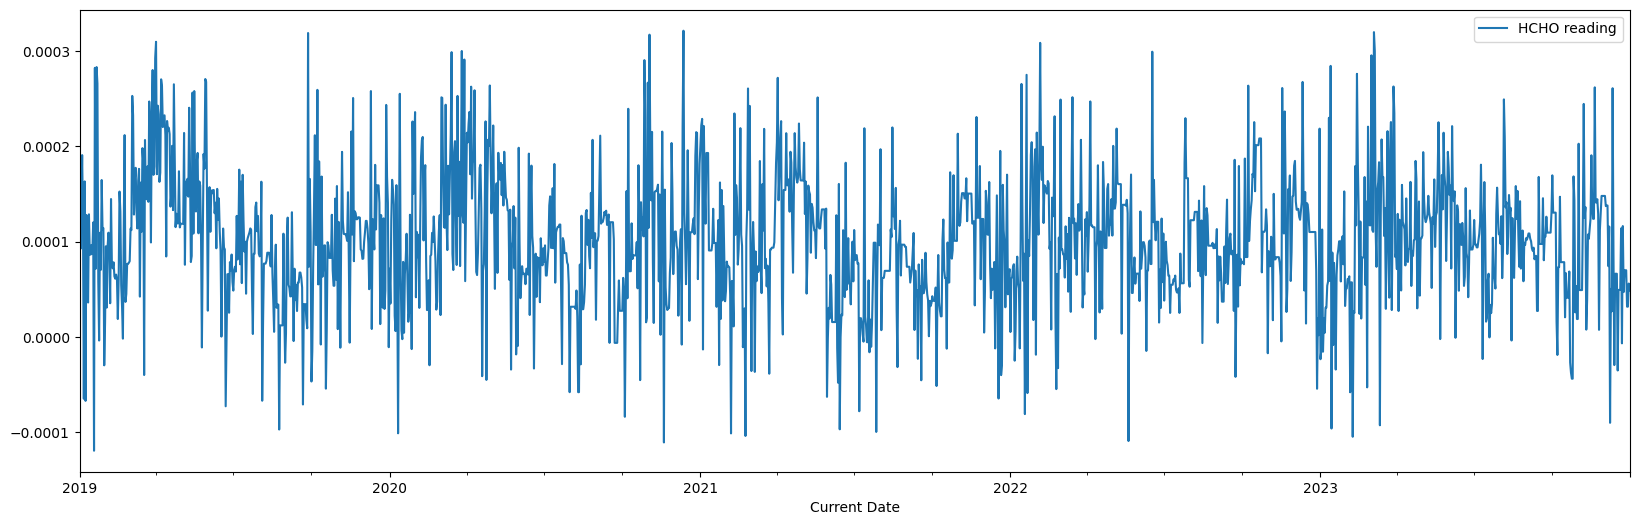

In [9]:
kandy_data.plot(figsize=(20, 6)) 

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
test_kandy = adfuller(kandy_data["HCHO reading"], autolag="AIC")

In [12]:
print("ADF value : ", test_kandy[0])
print("P value: ", test_kandy[1])
print("Num of Lags :", test_kandy[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_kandy[3])
for key, val in test_kandy[4].items():
    print("\t", key, ": ", val)

ADF value :  -6.900604814060024
P value:  1.2849822851718776e-09
Num of Lags : 17
Num of Observations used for ADF Regression and Critical Calculation : 1808
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


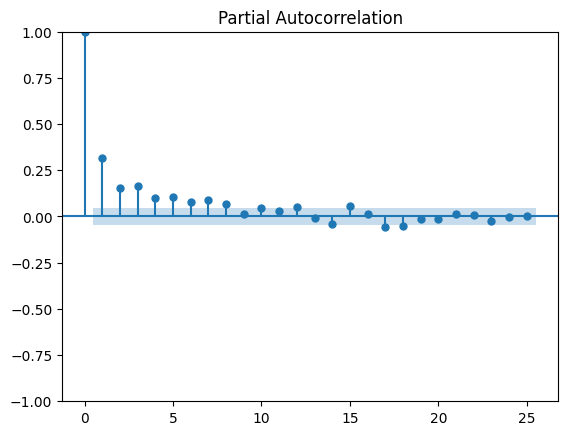

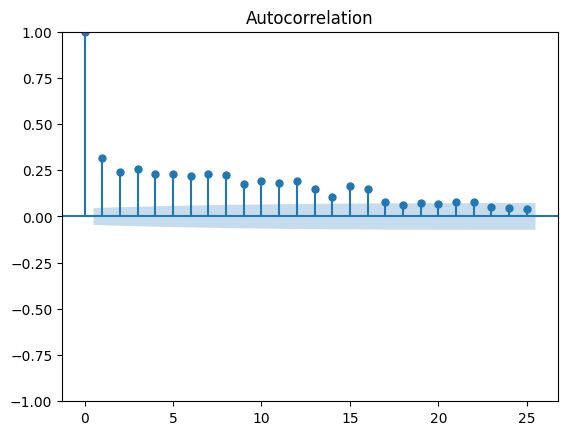

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(kandy_data["HCHO reading"], lags=25)
acf = plot_acf(kandy_data["HCHO reading"], lags=25)  

#### There is a small seasonality in kandy data due to majority of spikes are out of the boundary in the dataset

#### Kandy with LSTM

In [34]:
data = pd.read_csv("../NullValueHandled/KandyHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [35]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000176
1   2019-01-02      0.000092
2   2019-01-03      0.000134
3   2019-01-04      0.000191
4   2019-01-05      0.000122


In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length]) 
    return np.array(X), np.array(y) 

sequence_length = 5 
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)
 
model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005) 
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 33s 293ms/step - loss: 1.0545 - mean_squared_error: 1.0545 - val_loss: 0.6084 - val_mean_squared_error: 0.6084
Epoch 2/100
37/37 [==============================] - 5s 127ms/step - loss: 0.9604 - mean_squared_error: 0.9604 - val_loss: 0.5792 - val_mean_squared_error: 0.5792
Epoch 3/100
37/37 [==============================] - 5s 127ms/step - loss: 0.9334 - mean_squared_error: 0.9334 - val_loss: 0.5748 - val_mean_squared_error: 0.5748
Epoch 4/100
37/37 [==============================] - 5s 135ms/step - loss: 0.9388 - mean_squared_error: 0.9388 - val_loss: 0.6283 - val_mean_squared_error: 0.6283
Epoch 5/100
37/37 [==============================] - 5s 129ms/step - loss: 0.9277 - mean_squared_error: 0.9277 - val_loss: 0.6005 - val_mean_squared_error: 0.6005
Epoch 6/100
37/37 [==============================] - 5s 130ms/step - loss: 0.9136 - mean_squared_error: 0.9136 - val_loss: 0.5668 - val_mean_squared_error: 0.5668
Epoch 7/100
37/37 [==

37/37 [==============================] - 5s 138ms/step - loss: 0.8111 - mean_squared_error: 0.8111 - val_loss: 0.6028 - val_mean_squared_error: 0.6028
Epoch 52/100
37/37 [==============================] - 5s 135ms/step - loss: 0.8187 - mean_squared_error: 0.8187 - val_loss: 0.6131 - val_mean_squared_error: 0.6131
Epoch 53/100
37/37 [==============================] - 5s 136ms/step - loss: 0.8116 - mean_squared_error: 0.8116 - val_loss: 0.7578 - val_mean_squared_error: 0.7578
Epoch 54/100
37/37 [==============================] - 5s 134ms/step - loss: 0.8094 - mean_squared_error: 0.8094 - val_loss: 0.5975 - val_mean_squared_error: 0.5975
Epoch 55/100
37/37 [==============================] - 5s 129ms/step - loss: 0.8119 - mean_squared_error: 0.8119 - val_loss: 0.6315 - val_mean_squared_error: 0.6315
Epoch 56/100
37/37 [==============================] - 5s 131ms/step - loss: 0.8192 - mean_squared_error: 0.8192 - val_loss: 0.6526 - val_mean_squared_error: 0.6526
Epoch 57/100
37/37 [=========

12/12 [==============================] - 7s 34ms/step


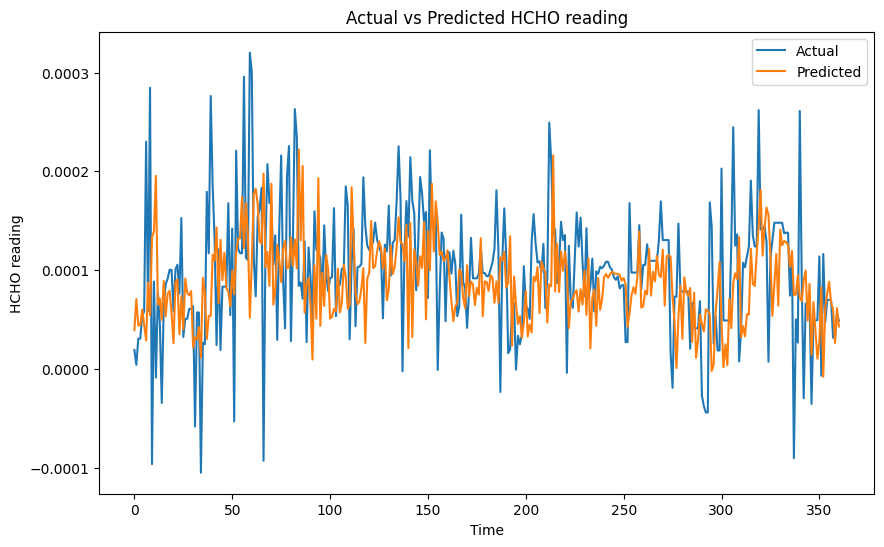

In [37]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [38]:
predictions.shape 

(361, 1)

46/46 [==============================] - 2s 37ms/step


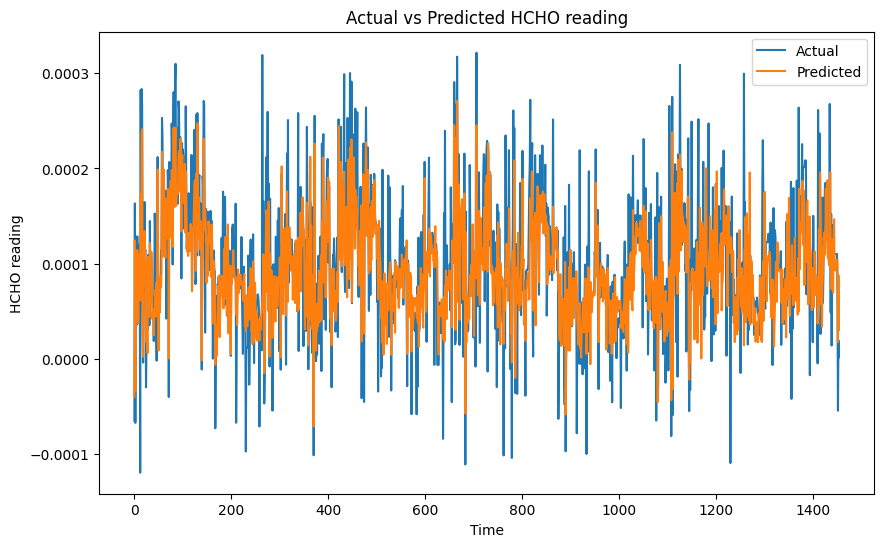

In [39]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 2s 35ms/step


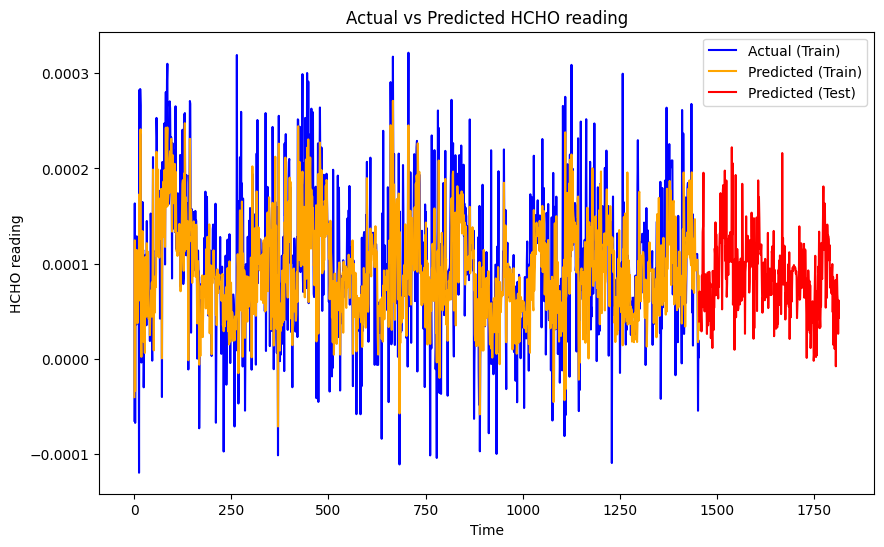

In [40]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [41]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.5181295102849051
Mean Absolute Error (MAE): 3.419645889366831e-05
Mean Squared Error (MSE): 2.2988523526856107e-09
Root Mean Squared Error (RMSE): 4.7946348689817984e-05
Median Absolute Error: 2.4984728885118213e-05
Explained Variance Score: 0.5346444065516949


#### Kandy with FB prophet

10:11:56 - cmdstanpy - INFO - Chain [1] start processing
10:11:56 - cmdstanpy - INFO - Chain [1] done processing


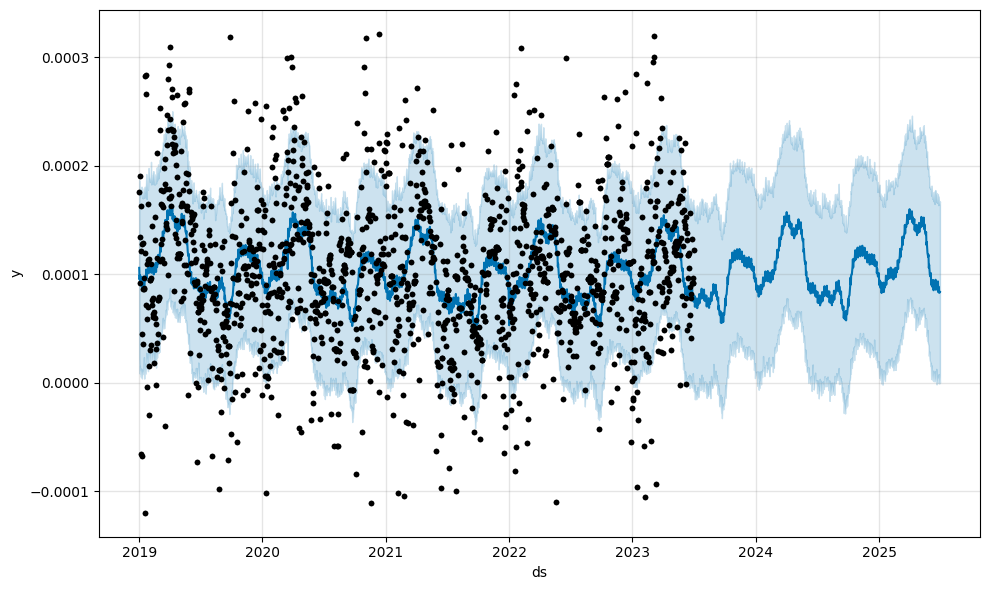

In [33]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/KandyHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds']) 

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-12-31']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.9 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=730)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()

#### Kandy Multi Variate Model 

In [9]:
data = pd.read_csv("../AnalysedFinalData/kandyData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   int64  
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   float64
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [11]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [12]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000176,Kandy Proper,7.29,80.63,500,0.09,71.096,79.592,65.354,1476000,1940,760.82,52.76,0.033072,0.000012,0.116477,0,0,Before,Before
1,2019-01-02,0.000092,Kandy Proper,7.29,80.63,500,0.01,70.124,78.764,63.716,1476000,1940,760.82,52.76,0.032599,0.000013,0.116477,0,0,Before,Before
2,2019-01-03,0.000134,Kandy Proper,7.29,80.63,500,0.02,69.728,79.448,62.240,1476000,1940,760.82,52.76,0.031031,0.000016,0.116477,0,0,Before,Before
3,2019-01-04,0.000191,Kandy Proper,7.29,80.63,500,0.00,69.224,79.610,61.214,1476000,1940,760.82,52.76,0.030439,0.000010,0.116477,0,0,Before,Before
4,2019-01-05,0.000122,Kandy Proper,7.29,80.63,500,0.04,72.068,82.526,64.040,1476000,1940,760.82,52.76,0.031700,0.000014,0.116477,0,0,Before,Before


#### remove constant data

In [13]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [14]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [15]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000176,0.09,71.096,79.592,65.354,1476000,760.82,0.033072,0.000012,0.116477,0,0,Before,Before
1,2019-01-02,0.000092,0.01,70.124,78.764,63.716,1476000,760.82,0.032599,0.000013,0.116477,0,0,Before,Before
2,2019-01-03,0.000134,0.02,69.728,79.448,62.240,1476000,760.82,0.031031,0.000016,0.116477,0,0,Before,Before
3,2019-01-04,0.000191,0.00,69.224,79.610,61.214,1476000,760.82,0.030439,0.000010,0.116477,0,0,Before,Before
4,2019-01-05,0.000122,0.04,72.068,82.526,64.040,1476000,760.82,0.031700,0.000014,0.116477,0,0,Before,Before


#### Encode Categorical data

In [16]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [17]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000176,0.09,71.096,79.592,65.354,1476000,760.82,0.033072,0.000012,0.116477,0,0,1,1
1,2019-01-02,0.000092,0.01,70.124,78.764,63.716,1476000,760.82,0.032599,0.000013,0.116477,0,0,1,1
2,2019-01-03,0.000134,0.02,69.728,79.448,62.240,1476000,760.82,0.031031,0.000016,0.116477,0,0,1,1
3,2019-01-04,0.000191,0.00,69.224,79.610,61.214,1476000,760.82,0.030439,0.000010,0.116477,0,0,1,1
4,2019-01-05,0.000122,0.04,72.068,82.526,64.040,1476000,760.82,0.031700,0.000014,0.116477,0,0,1,1


#### Check correlations

In [18]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.023929
TAVG                    0.162298
TMAX                    0.248444
TMIN                   -0.044744
Population             -0.056112
population_density     -0.056123
carbon_monoxide         0.186016
nitogen_dioxide         0.114099
ozone                  -0.014814
new_covid_patients     -0.078542
total_covid_patients   -0.046318
lockdown_status        -0.028364
covid_range_status     -0.023184
Name: HCHO reading, dtype: float64

In [19]:
data.shape

(1826, 15)